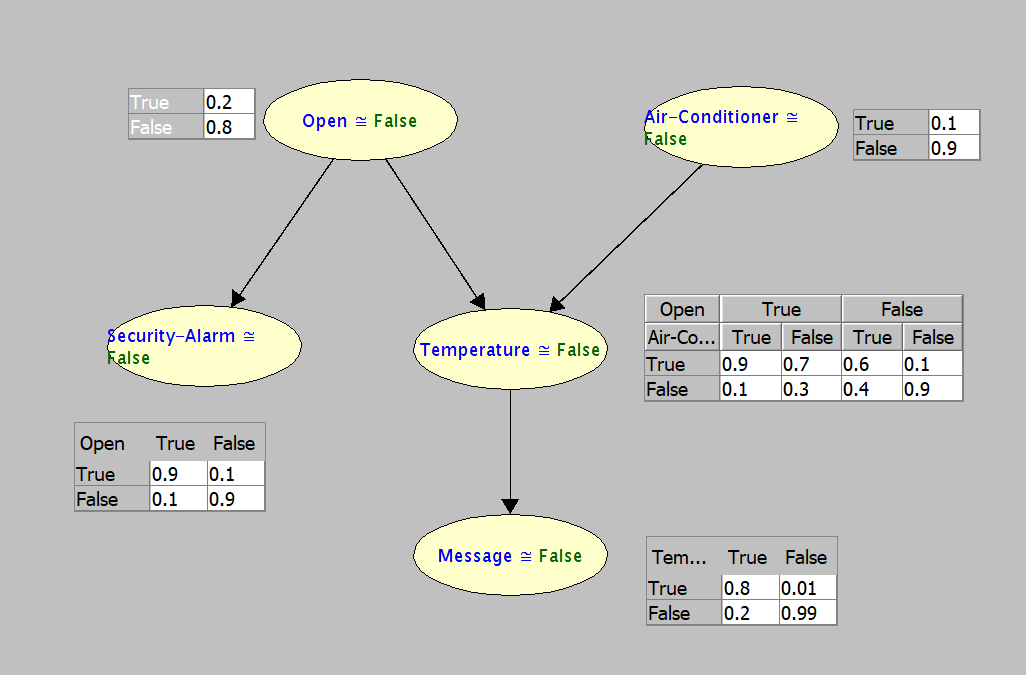


P(O,A,S,T,M) = P(O).P(A).P(S|O).P(T|O,A).P(M|T)
is the joint distribution probability.

(b)


(i). O, A are independent according to the converging connection rule in d-separation

(ii). The same explanation of (i) holds to say that this is false.

(iii). Using the diverging rule of d-separation, S, M are independent given either O or T or both. So, this statement is false.

(iv). Using the above explanation, we can say that this statement is true.


(d)

(i). P(m|t) = 0.8, P(\~m|t) = 0.2

P(m|\~t) = 0.01, P(\~m|\~t) = 0.99

(ii). P(s|a) = 0.26, P(\~s|a) = 0.74

P(s|\~a) = 0.26, P(\~s|\~a) = 0.74

(iii). P(t|a,s) = 0.8077, P(\~t|a,s) = 0.1923

P(t|\~a,s) = 0.5154, P(~t|\~a,s) = 0.4846

P(t|a,\~s) = 0.6081, P(\~t|a,\~s) = 0.3919

P(t|\~a,\~s) = 0.1162, P(\~t|\~a,\~s) = 0.8838

(iv). P(s|a,t) = 0.3182, P(\~s|a,t) = 0.6818

P(s|\~a,t) = 0.6091, P(\~s|\~a,t) = 0.3909

P(s|a,\~t) = 0.1471, P(\~s|a,\~t) = 0.8529

P(s|\~a,\~t) = 0.1615, P(\~s|\~a,\~t) = 0.8385

(v). P(a|m) = 0.2431, P(\~a|m) = 0.7569

P(a|\~m) = 0.06, P(\~a|\~m) = 0.94

(vi). P(m|s) = 0.4402, P(~m|s) = 0.5598

P(m|\~s) = 0.1407, P(\~m|\~s) = 0.8593


In [ ]:
import itertools, copy

class RandomVariable:
    '''
    Class to hold metadata about each random variable.
    '''

    def __init__(self, name, denotion, values, parents, children, cpt):
        self.name = name
        self.denotion = denotion
        self.values = values
        self.parents = parents
        self.children = children
        self.cpt = cpt

    def __str__(self):
        return self.name
    
    def call_build_distribution(self):
        if self.parents:
            dis = self.build_distribution(self.parents, 0)
            cpt = {self.denotion:{value:copy.deepcopy(dis) for value in self.values}}
        else:
            cpt = {self.denotion:{value:0 for value in self.values}}
        self.cpt = cpt
        return 
    
    def build_distribution(self, rvars, index):
        if (index+1) == len(rvars):
            iter_dis = {rvars[index].denotion:{value:0 for value in rvars[index].values}}
            return iter_dis
        else:
            next_iter_dict = self.build_distribution(rvars, index+1)
            iter_dis = {rvars[index].denotion:{value:copy.deepcopy(next_iter_dict) for value in rvars[index].values}}
            return iter_dis

    def display_node(self):
        print('Name: ', self.name)
        print('Denoted by: ', self.denotion)
        print('Values: ', self.values)
        print('Parents: ', [parent.name for parent in self.parents or []])
        print('Children: ', [child.name for child in self.children or []])
        print("CPT: ")
        print(self.cpt)


class BayesianNetwork():
    '''
    Bayesian network class to hold the network of nodes.
    It extends the itertools class to make use of combinations method by overriding it.
    '''

    def __init__(self, random_vars):
        self.random_vars = random_vars

    
    def combinations(self, n, item_list):
        single_list = [__ for _ in item_list for __ in _]
        combs = itertools.combinations(single_list, n)
        valid_combs = []
        for comb in combs:
            flag = False
            for sub_list in item_list:
                for comb_2 in itertools.combinations(comb, 2):
                    if all(x in sub_list for x in comb_2):
                        flag = True
                        break
                if flag:
                    break
            if not flag:
                valid_combs.append(dict(comb))
        return valid_combs
    
    def build_distribution(self, rvars, index):
        if (index+1) == len(rvars):
            iter_dis = {rvars[index].denotion:{value:0 for value in rvars[index].values}}
            return iter_dis
        else:
            next_iter_dict = self.build_distribution(rvars, index+1)
            iter_dis = {rvars[index].denotion:{value:copy.deepcopy(next_iter_dict) for value in rvars[index].values}}
            return iter_dis


    def enum_ask(self, query, evidence):
        query_list = [[(rv.denotion,value) for value in rv.values] for rv in query+evidence]
        query_combinations = self.combinations(len(query+evidence), query_list)
        distribution = self.build_distribution(query+evidence, 0)
        self.call_enum_all(query_combinations, distribution)
        self.normalize(distribution, query_combinations, query)
        return distribution
    
    def call_enum_all(self, query_combinations, distribution):
        for query in query_combinations:
            prob_dis = distribution 
            query_items = list(query.items())
            for i in range(len(query)-1):
                prob_dis = prob_dis[query_items[i][0]][query_items[i][1]]
            i+=1
            prob_dis[query_items[i][0]][query_items[i][1]] = self.enum_all(query)
        return 
    
    def enum_all(self, query):
        marginilaise_vars = [rv for rv in self.random_vars if rv.denotion not in query.keys()]
        marginalize_query_list = [[(rv.denotion,value) for value in rv.values] for rv in marginilaise_vars]
        marg_query_comb = self.combinations(len(marginilaise_vars), marginalize_query_list)
        new_queries = [copy.deepcopy(dict(query.items()|marg_query.items())) for marg_query in marg_query_comb]
        total_prob = 0
        for que in new_queries:
            marg_prob = 1
            for rv in self.random_vars:
                prob = rv.cpt[rv.denotion][que[rv.denotion]]
                for parent in rv.parents or []:
                    prob = prob[parent.denotion][que[parent.denotion]]
                marg_prob = marg_prob*prob
            total_prob += marg_prob
        return total_prob

    def normalize(self, distribution, query_combinations, query_vars):
        query_vars = [var.denotion for var in query_vars]
        normalize_dict = {}
        for comb in query_combinations:
            key = ''
            value = distribution
            for item in comb.items():
                value = value[item[0]][item[1]]
                if not item[0] in query_vars:
                    key += str(item[0])+str(item[1])
            if key not in normalize_dict.keys():
                normalize_dict[key] = value
            else:
                normalize_dict[key] += value
        for comb in query_combinations:
            key = ''
            value = distribution
            items = list(comb.items())
            for i in range(len(items)-1):
                value = value[items[i][0]][items[i][1]]
                if not items[i][0] in query_vars:
                    key += str(items[i][0])+str(items[i][1])
            i+=1
            key += str(items[i][0])+str(items[i][1])
            value[items[i][0]][items[i][1]] = (value[items[i][0]][items[i][1]]/normalize_dict[key])

def main():
    burglary = RandomVariable('Burglary', 'B', [True, False], None, None, None)
    earthquake = RandomVariable('Earthquake', 'E', [True, False], None, None, None)
    alarm = RandomVariable('Alarm', 'A', [True, False], None, None, None)
    johncalls = RandomVariable('JohnCalls', 'J', [True, False], None, None, None)
    marycalls = RandomVariable('MaryCalls', 'M', [True, False], None, None, None)
    burglary.children = [alarm]
    earthquake.children = [alarm]
    alarm.children = [johncalls, marycalls]
    alarm.parents = [burglary, earthquake]
    johncalls.parents = [alarm]
    marycalls.parents = [alarm]
    nodes = [burglary, earthquake, alarm, johncalls, marycalls]
    for node in nodes: node.call_build_distribution()
    burglary.cpt['B'][True] = 0.001; burglary.cpt['B'][False] = 0.999
    earthquake.cpt['E'][True] = 0.002; earthquake.cpt['E'][False] = 0.998 
    alarm.cpt['A'][True]['B'][True]['E'][True] = 0.95 
    alarm.cpt['A'][True]['B'][True]['E'][False] = 0.94 
    alarm.cpt['A'][True]['B'][False]['E'][True] = 0.29 
    alarm.cpt['A'][True]['B'][False]['E'][False] = 0.001
    alarm.cpt['A'][False]['B'][True]['E'][True] = 0.05 
    alarm.cpt['A'][False]['B'][True]['E'][False] = 0.06 
    alarm.cpt['A'][False]['B'][False]['E'][True] = 0.71 
    alarm.cpt['A'][False]['B'][False]['E'][False] = 0.999
    johncalls.cpt['J'][True]['A'][True] = 0.9
    johncalls.cpt['J'][True]['A'][False] = 0.05
    johncalls.cpt['J'][False]['A'][True] = 0.1
    johncalls.cpt['J'][False]['A'][False] = 0.95
    marycalls.cpt['M'][True]['A'][True] = 0.7
    marycalls.cpt['M'][True]['A'][False] = 0.01
    marycalls.cpt['M'][False]['A'][True] = 0.3
    marycalls.cpt['M'][False]['A'][False] = 0.99

    bayes_network = BayesianNetwork(nodes)
    queries = [[[johncalls],[burglary, earthquake]],[[alarm],[burglary]],[[earthquake], [marycalls]], [[burglary], [alarm]], \
        [[johncalls, marycalls], [alarm]], [[johncalls], [alarm]], [[marycalls], [alarm]]]
    for query in queries:
        distribution = bayes_network.enum_ask(query[0], query[1])
        print('For the query: ', [[var.__str__() for var in q] for q in query])
        print(distribution)
        print()
    
if __name__ == '__main__':
    main()


For the query:  [['JohnCalls'], ['Burglary', 'Earthquake']]
{'J': {True: {'B': {True: {'E': {True: 0.8574999999999999, False: 0.849}}, False: {'E': {True: 0.29650000000000004, False: 0.050850000000000006}}}}, False: {'B': {True: {'E': {True: 0.1425, False: 0.151}}, False: {'E': {True: 0.7035, False: 0.9491499999999999}}}}}}

For the query:  [['Alarm'], ['Burglary']]
{'A': {True: {'B': {True: 0.94002, False: 0.001578}}, False: {'B': {True: 0.05997999999999999, False: 0.998422}}}}

For the query:  [['Earthquake'], ['MaryCalls']]
{'E': {True: {'M': {True: 0.03588091528645573, False: 0.0015976396500871496}}, False: {'M': {True: 0.9641190847135442, False: 0.9984023603499128}}}}

For the query:  [['Burglary'], ['Alarm']]
{'B': {True: {'A': {True: 0.373551228281836, False: 6.01313169715425e-05}}, False: {'A': {True: 0.6264487717181639, False: 0.9999398686830285}}}}

For the query:  [['JohnCalls', 'MaryCalls'], ['Alarm']]
{'J': {True: {'M': {True: {'A': {True: 0.6299999999999999, False: 0.0005

From the above distributions, it is clear that P(J,M|A) = P(J|A).P(M|A)

Hence, J,M are conditionally independent given A.